### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Tercera tarea programada 2022-I


Estudiantes: Juan Ignacio Navarro Navarro

## Ejercicio 1

### 1) Descipción del problema y objetivo del ejercicio

El objetivo de este ejercicio es practicar la implementación de una CNN utilizando PyTorch para un conjunto de datos que funciona como modelo para la clasificación de animales.

En general como problema se tiene que el análisis de imágenes individualmente por una persona es sencillo si esta conoce todos los animales posibeles pero tiene dos problemas. El primero es que si esta persona no conoce el animal no lo va a poder clasificar y el segundo es que una persona dura mucho en realizar esta acción. Es por esto que el desarrollo de una red neuronal convolucional es de gran utilidad porque podrá realizar el análisis de millones de imágenes en poco tiemop y hacer un reconocimiento casi inmediato para todas. La cantidad de aplicaciones que se pueden aprovechar de este rápido reconocimiento automaticado son muchas y pueden favorecer los trabajos simples en las investigaciones. 

### 2) Describa los datos utilizados en el ejercicio

Los datos utilizados en el ejercicio corresponden a los almacenados en el siguiente repositorio https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals?resource=download 

Estos datos corresponden a un total de 5400 imágenes de 90 animales distintos los cuales fueron clasificados en carpetas. Todas estas imágenes son útiles para entrenar el modelo que luego va a reconocer alguna imagen de estas o similar y la va a clasificar en porcentajes de la especie a la cuál pertenee.

### 3) Cargue, normalice y explore los datos

A continuación se importan las bilbiotecas necesarias para el análisis.

In [62]:
# Bibliotecas requeridas para el ejercicio

import numpy as np

# Para graficar
%matplotlib inline
import matplotlib.pyplot as plt

#Bibliotecas generales
import torch
import torchvision
import torchvision.transforms as transforms

# Redes neuronales
import torch.nn as nn
import torch.nn.functional as F

# Pérdida y optimización
import torch.optim as optim

El siguiente paso es la carga y normalización de los datos

In [76]:
# Carga de los datos divididos en datos de entrenamiento y validación.

transform = transforms.Compose(
    [transforms.Resize(255),
     transforms.CenterCrop(224),
     transforms.ToTensor()])
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Cargador de datos de entrenamiento.
#Se definen objetos (tipo DataLoader) para la carga de los datos 
#en mini batches ,
trainset = torchvision.datasets.ImageFolder('./animals/animals', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

#Datos de prueba
testset = torchvision.datasets.ImageFolder('./animals/animals', transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Clases asociadas a las imágenes
classes =   ('antelope','badger','bat','bear','bee','beetle','bison','boar',
            'butterfly','cat','caterpillar','chimpanzee','cockroach','cow',
            'coyote','crab','crow','deer','dog','dolphin','donkey','dragonfly',
            'duck','eagle','elephant','flamingo','fly','fox','goat','goldfish',
            'goose','gorilla','grasshopper','hamster','hare','hedgehog','hippopotamus','hornbill','horse','hummingbird',
            'hyena','jellyfish','kangaroo','koala','ladybugs','leopard',
            'lion','lizard','lobster','mosquito',
            'moth','mouse', 'octopus', 'okapi','orangutan','otter','owl','ox','oyster',
            'panda', 'parrot','pelecaniformes','penguin','pig','pigeon',
            'porcupine','possum','raccoon','rat','reindeer','rhinoceros',
            'sandpiper','seahorse','seal','shark','sheep','snake','sparrow',
            'squid','squirrel','starfish','swan','tiger','turkey','turtle',
            'whale','wolf','wombat','woodpecker','zebra')


Exploración de los datos

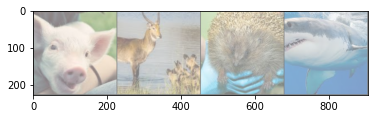

  pig antelope hedgehog shark
torch.Size([3, 228, 906])


In [78]:
# Funciones para desplegar algunas imágenes de forma aleatoria. 

def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# obtener imágenes del conjunto de entrenamiento al azar
dataiter = iter(trainloader)
images, labels = dataiter.next()


# mostrar las imágenes
imshow(torchvision.utils.make_grid(images))

# mostrar las etiquetas

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

print(torchvision.utils.make_grid(images).shape)


### 4) Calcule algunas estadísticas importantes, por ejemplo cantidad de registros por clase para verificar si las clases están balanceadas

In [79]:
def registros_por_clase(labels):
    """
    Este método calcula la cantidad de imágenes que hay en
    cada clase para ver si están bien balanceadas
    """
    lista_registros = [0] * 90
    for label in labels:
        lista_registros[label]+=1
    print("Resumen de balance de registros:\n")
    for i in range(90):
        print("En la clase " + classes[i] + " hay ", lista_registros[i], " registros.")

registros_por_clase(labels)



Resumen de balance de registros:

En la clase antelope hay  1  registros.
En la clase badger hay  0  registros.
En la clase bat hay  0  registros.
En la clase bear hay  0  registros.
En la clase bee hay  0  registros.
En la clase beetle hay  0  registros.
En la clase bison hay  0  registros.
En la clase boar hay  0  registros.
En la clase butterfly hay  0  registros.
En la clase cat hay  0  registros.
En la clase caterpillar hay  0  registros.
En la clase chimpanzee hay  0  registros.
En la clase cockroach hay  0  registros.
En la clase cow hay  0  registros.
En la clase coyote hay  0  registros.
En la clase crab hay  0  registros.
En la clase crow hay  0  registros.
En la clase deer hay  0  registros.
En la clase dog hay  0  registros.
En la clase dolphin hay  0  registros.
En la clase donkey hay  0  registros.
En la clase dragonfly hay  0  registros.
En la clase duck hay  0  registros.
En la clase eagle hay  0  registros.
En la clase elephant hay  0  registros.
En la clase flamingo h

### 5) Defina la red convolucional

In [80]:
# Crear el modelo de aprendizaje profundo, se crea una clase 
# que envuelve la clase nn.Module 
# Para profundizar en las entradas y salidas por capa consulte [4] y [8]

class CNNet(nn.Module):
    # Modelo de red convolucional.
    # :params
    #    torch.nn.Module clase que implenta la funionalidad de
    #    redes neuronales de Pytorch 

    def __init__(self): 
        # Función para definir e inicializar la red.
        super(CNNet, self).__init__()

        #capa convolucional
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size...
        self.conv1 = nn.Conv2d(3, 6, 5)

        #torch.nn.MaxPool2d(kernel_size, stride,...        
        self.pool = nn.MaxPool2d(2, 2)  

        #torch.nn.Conv2d(in_channels, out_channels, kernel_size...
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        #Capas perceptrón del modelo
        self.fc1 = nn.Linear(44944, 200)
        
        self.fc2 = nn.Linear(200, 110)
        
        #Salida a 10 clases 
        self.fc3 = nn.Linear(110, 90)

    def forward(self, x):
        # Aplica el modelo a los datos de entrada.
        # :param
        #   x : datos de la imagen a procesar.
        
        #Pase de la entrada por todas las capas de la red.
        #print("Tamaño del x de entrada al entrenamiento:" , x.shape)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print("Tamaño de x luego de la convolución y pool:", x.shape)
        x = x.view(-1, 44944)
        #x = torch.flatten(x, 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = CNNet()

### 6) Defina los hiper-parámetros de entranamiento, por ejemplo, función de pérdida y el optimizador

Estos dos se definen a continuación

In [81]:
# Función de pérdida es de entropía cruzada
criterion = nn.CrossEntropyLoss()

# Optimización por descenso de gradiente estocástico (Stochastic Gradient Descent - SGD)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 7) Separe las muestras en datos de entrenamiento y validación y entrene el modelo

A continuación se presenta el entrenamiento de la red

In [82]:
# cantidad de ciclos de entrenamiento o épocas
numEpoch = 2

print("length")
print(len(trainloader))

for epoch in range(numEpoch):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # obtener los datos de entrada; 
        # data es una lista de la forma [inputs, labels]
        inputs, labels = data


        # inicializar los parámetros del gradiente.
        optimizer.zero_grad()

        # Se realizan las predicciones con el modelo. 
        # Este código ejecuta el forward de las entradas.
        outputs = net(inputs)
        
        # Se calcula la pérdida utilizando Cross Entropy Loss
        loss = criterion(outputs, labels)       
        loss.backward()
        
        #El optimizador realiza las actualizaciones a través del método step().
        optimizer.step()


        # imprimir estadisticas
        running_loss += loss.item()
        if i % 100 == 99:    # imprimir mensaje cada 2000 mini-batches
            print('[%d, %5d] pérdida: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Fin del entrenamiento')

length
1350
[1,   100] pérdida: 4.493
[1,   200] pérdida: 4.506
[1,   300] pérdida: 4.508
[1,   400] pérdida: 4.498
[1,   500] pérdida: 4.500
[1,   600] pérdida: 4.499
[1,   700] pérdida: 4.501
[1,   800] pérdida: 4.500
[1,   900] pérdida: 4.500
[1,  1000] pérdida: 4.495
[1,  1100] pérdida: 4.470
[1,  1200] pérdida: 4.475
[1,  1300] pérdida: 4.476
[2,   100] pérdida: 4.390
[2,   200] pérdida: 4.434
[2,   300] pérdida: 4.406
[2,   400] pérdida: 4.447
[2,   500] pérdida: 4.418
[2,   600] pérdida: 4.400
[2,   700] pérdida: 4.358
[2,   800] pérdida: 4.359
[2,   900] pérdida: 4.390
[2,  1000] pérdida: 4.344
[2,  1100] pérdida: 4.368
[2,  1200] pérdida: 4.307
[2,  1300] pérdida: 4.339
Fin del entrenamiento
